In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
import time

In [68]:
df2 = pd.read_csv(r'DataSets\prices.csv')
info = pd.read_csv(r'DataSets\securities.csv')
df2['Daily Return'] = df2['close'] - df2['open']

In [69]:
df2.shape

(851264, 8)

In [70]:
info.shape

(505, 8)

In [71]:
info = info[info['Ticker symbol'].isin(df2['symbol'])]
info = info[['Ticker symbol', 'GICS Sector', 'GICS Sub Industry']]

In [72]:
df2

,date,symbol,open,close,low,high,volume,Daily Return
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2.409996
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,-5.259995
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,-1.430000
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,1.140000
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,-2.040001
...,...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,-0.110001
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,-0.029999
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,-0.110000
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0,0.720001


In [73]:
df2.isnull().sum()

date            0
symbol          0
open            0
close           0
low             0
high            0
volume          0
Daily Return    0
dtype: int64

In [74]:
df2['symbol'].value_counts()

symbol
KSU     1762
NOC     1762
ORCL    1762
OMC     1762
OKE     1762
        ... 
KHC      378
HPE      304
CSRA     284
WLTW     251
FTV      126
Name: count, Length: 501, dtype: int64

In [75]:
df2 = df2.merge(info, left_on='symbol', right_on='Ticker symbol')

In [76]:
def add_moving_averages(df, column='Close', sma_window=5, ema_window=10):

    df[f'SMA_{sma_window}'] = df.groupby('symbol')[column].transform(lambda x: x.rolling(window=sma_window).mean())
    df[f'EMA_{ema_window}'] = df.groupby('symbol')[column].transform(lambda x: x.ewm(span=ema_window, adjust=False).mean())

    return df
def add_rsi(df, column='Close', window=14):
    delta = df[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    df[f'RSI_{window}'] = 100 - (100 / (1 + rs))
    return df

def add_macd(df, column='Close', short_window=12, long_window=26, signal_window=9):
    df['MACD_line'] = df[column].ewm(span=short_window, adjust=False).mean() - df[column].ewm(span=long_window, adjust=False).mean()
    df['MACD_signal'] = df['MACD_line'].ewm(span=signal_window, adjust=False).mean()
    return df




In [77]:
add_moving_averages(df2, column='close', sma_window=5, ema_window=10)
#add_moving_averages(df2, column='close', sma_window=20, ema_window=50)
#add_rsi(df2, column='close', window=14)
add_macd(df2, column='close', short_window=12, long_window=26, signal_window=9)

,date,symbol,open,close,low,high,volume,Daily Return,Ticker symbol,GICS Sector,GICS Sub Industry,SMA_5,EMA_10,MACD_line,MACD_signal
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2.409996,WLTW,Financials,Insurance Brokers,NaN,125.839996,0.000000,0.000000
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,-5.259995,WLTW,Financials,Insurance Brokers,NaN,124.774543,-0.467464,-0.093493
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,-1.430000,WLTW,Financials,Insurance Brokers,NaN,122.988262,-1.229637,-0.320722
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,1.140000,WLTW,Financials,Insurance Brokers,NaN,121.830396,-1.679549,-0.592487
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,-2.040001,WLTW,Financials,Insurance Brokers,118.472000,120.583052,-2.144528,-0.902895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,-0.110001,ZBH,Health Care,Health Care Equipment,103.043999,103.008135,-2.805761,-5.486220
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,-0.029999,ZION,Financials,Regional Banks,43.380000,43.114522,-4.163148,-5.221606
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,-0.110000,ZTS,Health Care,Pharmaceuticals,53.617999,53.107125,-4.342375,-5.045759
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0,0.720001,AIV,Real Estate,REITs,44.686001,44.375040,-5.077868,-5.052181


In [78]:
df2['Yesterday High'] = df2.groupby('symbol')['high'].shift(1)
df2['Yesterday Low'] = df2.groupby('symbol')['low'].shift(1)
df2['Yesterday return'] = df2.groupby('symbol')['Daily Return'].shift(1)

In [79]:
df2.isnull().sum()
df2.dropna(inplace=True)
df2.shape

(849260, 18)

In [80]:
df2

,date,symbol,open,close,low,high,volume,Daily Return,Ticker symbol,GICS Sector,GICS Sub Industry,SMA_5,EMA_10,MACD_line,MACD_signal,Yesterday High,Yesterday Low,Yesterday return
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,-2.040001,WLTW,Financials,Insurance Brokers,118.472000,120.583052,-2.144528,-0.902895,117.440002,113.500000,1.140000
5,2016-01-12 00:00:00,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0,0.040001,WLTW,Financials,Insurance Brokers,116.414001,119.667952,-2.438120,-1.209940,117.330002,114.089996,-2.040001
6,2016-01-13 00:00:00,WLTW,116.459999,112.849998,112.589996,117.070000,949600.0,-3.610001,WLTW,Financials,Insurance Brokers,114.988000,118.428324,-2.855743,-1.539101,116.059998,114.500000,0.040001
7,2016-01-14 00:00:00,WLTW,113.510002,114.379997,110.050003,115.029999,785300.0,0.869995,WLTW,Financials,Insurance Brokers,114.874000,117.692265,-3.028345,-1.836950,117.070000,112.589996,-3.610001
8,2016-01-15 00:00:00,WLTW,113.330002,112.529999,111.919998,114.879997,1093700.0,-0.800003,WLTW,Financials,Insurance Brokers,114.056000,116.753671,-3.276642,-2.124888,115.029999,110.050003,0.869995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,-0.110001,ZBH,Health Care,Health Care Equipment,103.043999,103.008135,-2.805761,-5.486220,103.739998,102.830002,0.500000
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,-0.029999,ZION,Financials,Regional Banks,43.380000,43.114522,-4.163148,-5.221606,43.639999,42.630001,-0.479999
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,-0.110000,ZTS,Health Care,Pharmaceuticals,53.617999,53.107125,-4.342375,-5.045759,53.779999,53.400002,0.149998
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0,0.720001,AIV,Real Estate,REITs,44.686001,44.375040,-5.077868,-5.052181,44.840000,44.250000,0.340000


In [81]:
X = df2.drop(['date', 'symbol','Ticker symbol', 'close', 'Daily Return', 'high', 'low'], axis=1)
y = df2['Daily Return']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
# 'EMA_50', 'SMA_20', 'RSI_14' 

prep = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['open', 'volume', 'SMA_5',  'EMA_10','Yesterday High', 'Yesterday Low', 'Yesterday return', 'MACD_line', 'MACD_signal']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['GICS Sector', 'GICS Sub Industry'])
    ])

In [91]:
pipe = Pipeline(
    steps=[
        ('preprocessor', prep),
        ('model', LinearRegression())
    ])

In [92]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"--- {name} ---")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"R^2 Score: {r2:.3f}")
    print()


In [93]:
pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['open', 'volume', 'SMA_5',
                                                   'EMA_10', 'Yesterday High',
                                                   'Yesterday Low',
                                                   'Yesterday return',
                                                   'MACD_line',
                                                   'MACD_signal']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['GICS Sector',
                                                   'GICS Sub Industry'])])),
                ('model', LinearRegression())])

In [95]:
evaluate_model(pipe, X_test, y_test, "Linear Regression with  SMA5 and EMA10, Yesterday High, Low and Return, RSI14, and MACD")


--- Linear Regression with  SMA5 and EMA10, Yesterday High, Low and Return, RSI14, and MACD ---
Mean Absolute Error (MAE): 0.686
Mean Squared Error (MSE): 2.052
Root Mean Squared Error (RMSE): 1.432
R^2 Score: 0.036



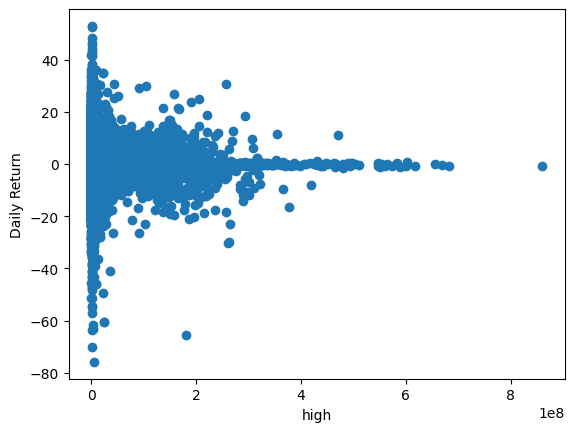

In [13]:
plt.scatter(df2['volume'], df2['Daily Return'])
plt.xlabel('high')
plt.ylabel('Daily Return')
plt.show()

In [14]:
start_time = time.time()
with tqdm(total=rfr.n_estimators, desc="Fitting model") as pbar:
    for i in range(rfr.n_estimators):
        rfr.set_params(n_estimators=i+1)  # Incrementally fitting
        rfr.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        estimated_total_time = (elapsed_time / (i+1)) * rfr.n_estimators
        remaining_time = estimated_total_time - elapsed_time
        pbar.set_postfix({"ETA": f"{remaining_time:.2f} sec"})
        pbar.update(1)

Fitting model:   0%|          | 0/2 [00:00<?, ?it/s]